# Dang Thanh Vu - 197796

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

def BSAS(X,theta,q,order):
    N, l = X.shape[:]
    
    n_cluster = 1
    bel = -1*np.ones(N)
    bel[order[0]] = n_cluster
    repre = np.array([X[order[0]]])
    for i in range(1, N):
        dist = (repre-X[order[i]])**2
        dist = np.sqrt(np.sum(dist, axis=1))
        s1 = np.min(dist)
        s2 = np.argmin(dist)
        if(s1 > theta) and (n_cluster < q):
            n_cluster = n_cluster + 1
            bel[order[i]] = n_cluster
            repre = np.concatenate([repre, [X[order[i]]]], axis=0)
        else:
            bel[order[i]] = s2
            repre[s2] = (((np.sum(bel==s2)-1)*repre[s2])+X[order[i]])/np.sum(bel==s2)
    return bel, repre

def k_means(X,theta):
    N, l = X.shape[:]
    m, l = theta.shape[:]
    e = 1
    iters = 0
    while(e > 10e-3):
        iters = iters + 1
        theta_old = theta.copy()
        dist_all = []
        for j in range(m):
            dist = np.sum((X - theta[j])**2, axis=1)
            dist_all.append(dist)
        bel = np.argmin(dist_all, axis=0)
        J = np.sum(np.min(dist_all, axis = 0))
        for j in range(m):
            if(np.sum(bel == j) != 0):
                theta[j] = np.sum(X*(np.tile(bel==j, (2, 1)).T), axis=0)/(1.0*np.sum(bel==j))
        e = np.sum(np.absolute(theta - theta_old))
    return theta, bel, J

def cost_comput(X, w):
    N, l = X.shape[:]
    m, l = w.shape[:]
    bel = np.zeros(N)
    cost = 0
    for i in range(N):
        t = np.zeros(m)
        for j in range(m):
            t[j] = np.sum((X[i] - w[j])**2)
        cost = cost + np.min(t)
        bel[i] = np.argmin(t)
    return bel, cost

def k_medoids(X,m):
    N, l = X.shape[:]
    a_init = np.random.permutation(N)
    a = a_init[:m]
    w_init = X[a]
    bel, cost = cost_comput(X, w_init)
    e = -1
    iters = 0
    while(e < 0):
        iters = iters + 1
        cost_old = cost
        for i in range(m):
            for j in range(N):
                a_temp = a.copy()
                if(np.sum(a_temp == j) == 0):
                    a_temp[i] = j
                    w_temp = X[a_temp]
                    bel_temp, cost_temp = cost_comput(X, w_temp)
                    if(cost_temp < cost):
                        bel = bel_temp
                        cost = cost_temp
                        a = a_temp
        e = cost - cost_old
    w = X[a]
    return bel, cost, w, a

def GMDAS(X,mv_ini,mc_ini,e,maxiter):
    mv = 1.0*mv_ini
    mc = 1.0*mc_ini
    N, l = X.shape[:]
    m, l = mv.shape[:]
    cp = np.ones((N, m))/m
    eps = (10e-6)*np.identity(l)
    
    iters = 0
    diff = e + 1
    mvold = mv
    mcold = mc
    apold = np.ones(m)/m
    diffvec = []
    while(iters < maxiter) and (diff > e):
        iters = iters + 1
        diffvec.append(diff)
        
        #prob
        auxvec = np.zeros((N, m))
        for j in range(N):
            dete=np.zeros(m)
            for i in range(m):
                dete[i] = np.linalg.det(mcold[i])
                d = np.reshape(X[j] - mvold[i], (1, l))
                dist = d @ np.linalg.inv(mcold[i] + eps) @ d.T
                auxvec[j, i] = ((((2*np.pi)**l)*dete[i])**(-.5))*np.exp(-.5*dist)*apold[i]
            sumaux = np.sum(auxvec, axis=1)
        loss = np.sum((sumaux))
        #c
        for j in range(N):
            for i in range(m):
                cp[j, i] = auxvec[j, i]/sumaux[j]
        
        temp = np.sum(cp, axis=0)
        ap = temp/N
        
        #mean
        for i in range(m):
            aux = np.zeros(l)
            for j in range(N):
                aux = aux + cp[j, i]*X[j]
            mv[i] = aux/temp[i]
        #cov
        for i in range(m):
            aux = np.zeros(l)
            for j in range(N):
                d = np.reshape(X[j] - mv[i], (1, l))
                aux = aux + cp[j, i]*(d.T @ d)
            mc[i] = aux/temp[i]
            
        diff = np.sum(np.abs(ap - apold)) + np.sum(np.abs(mv-mvold)) + np.sum(np.abs(mc-mcold))
       
        apold = ap
        mvold = mv
        mcold = mc
        
      
    return  ap, cp, mv, mc, iters, loss

# Exercise 7.4.1

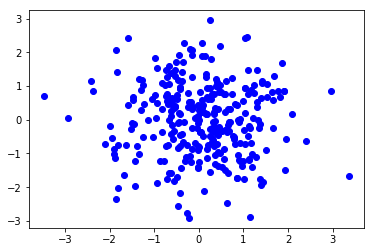

In [2]:
m1 = np.array([0, 0])
S1 = np.identity(2)
X = np.random.multivariate_normal(m1, S1, 300)
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()
n = 300

In [3]:
dista = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        dista[i, j] = np.sqrt(np.sum((X[i] - X[j])**2))
        dista[j, i] = dista[i, j]
maxdist = np.max(dista)
mindist = np.min(dista)
theta_min = 0.25*(maxdist + mindist)/2
theta_max = 1.75*(maxdist + mindist)/2
s = (theta_min + theta_max)/(50 - 1)
print("theta min %f, theta max %f, s %f" %(theta_min, theta_max, s))

theta min 0.903460, theta max 6.324218, s 0.147504


[22, 19, 16, 15, 12, 10, 9, 8, 7, 7, 6, 6, 4, 4, 4, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


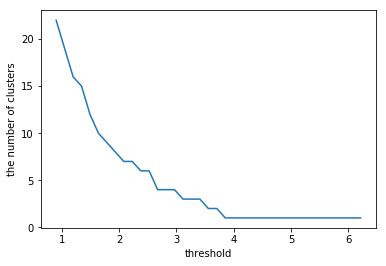

In [4]:
q = n
n_times = 10
m_tot = []
for theta in np.arange(theta_min, theta_max, s):
    list_m = np.zeros(q)
    for start in range(n_times):
        order = np.random.permutation(n)
        [bel, m] = BSAS(X, theta, q, order)
        list_m[m.shape[0]] = list_m[m.shape[0]] + 1
    m_size = np.argmax(list_m)
    m_tot.append(m_size)
print(m_tot)

plt.plot(np.arange(theta_min, theta_max, s), m_tot)
plt.xlabel("threshold")
plt.ylabel("the number of clusters")
plt.show()

# Exercise 7.5.1

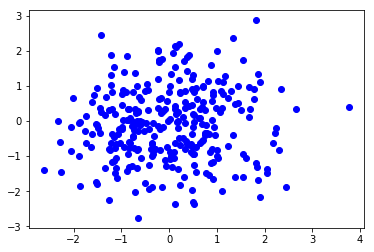

In [5]:
S1 = np.identity(2)
m1 = np.array([0, 0])

X = np.random.multivariate_normal(m1, S1, 300)
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

[[0.18761486 0.47723277]
 [0.87632891 0.70804796]
 [0.43238982 0.10319101]]


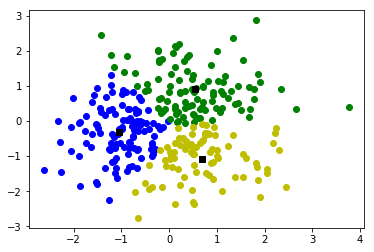

In [6]:
theta = np.random.rand(3, 2)
print(theta)
theta, bel, J = k_means(X, theta)

X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(theta[:, 0], theta[:, 1], "ks")
plt.show()

[[0.75846647 0.07197651]
 [0.59875599 0.12316002]]


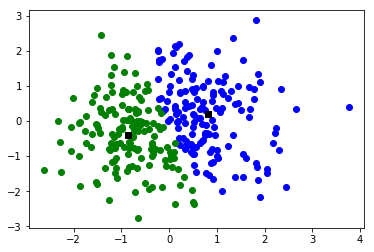

In [7]:
theta = np.random.rand(2, 2)
print(theta)
theta, bel, J = k_means(X, theta)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(theta[:, 0], theta[:, 1], "ks")
plt.show()

# Exercise 7.5.2

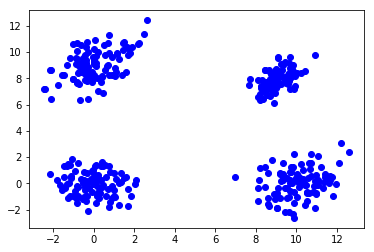

In [8]:
S1 = np.identity(2)
S2 = np.array([[1, 0.2], [0.2, 1.5]])
S3 = np.array([[1, 0.4], [0.4, 1.1]])
S4 = np.array([[0.3, 0.2], [0.2, 0.5]])
m1 = np.array([0, 0])
m2 = np.array([10, 0])
m3 = np.array([0, 9])
m4 = np.array([9, 8])
n = 100

x1 = np.random.multivariate_normal(m1, S1, n)
x2 = np.random.multivariate_normal(m2, S2, n)
x3 = np.random.multivariate_normal(m3, S3, n)
x4 = np.random.multivariate_normal(m4, S4, n)
X = np.concatenate([x1, x2, x3, x4])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

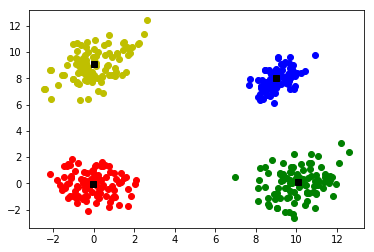

In [9]:
bel, cost, w, a = k_medoids(X, 4)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
X4 = X[np.where(bel == 3)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(w[:, 0], w[:, 1], "ks")
plt.show()

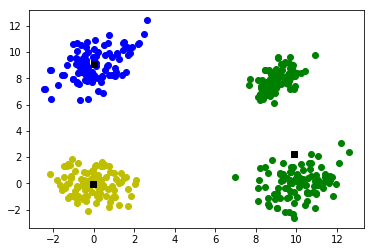

In [10]:
bel, cost, w, a = k_medoids(X, 3)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(w[:, 0], w[:, 1], "ks")
plt.show()

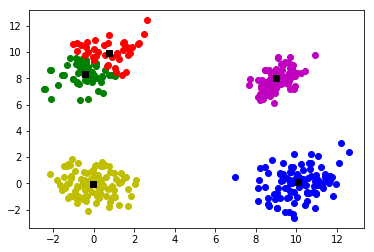

In [11]:
bel, cost, w, a = k_medoids(X, 5)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
X4 = X[np.where(bel == 3)]
X5 = X[np.where(bel == 4)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(X5[:, 0], X5[:, 1], "mo")
plt.plot(w[:, 0], w[:, 1], "ks")
plt.show()

# Exercise 7.5.3

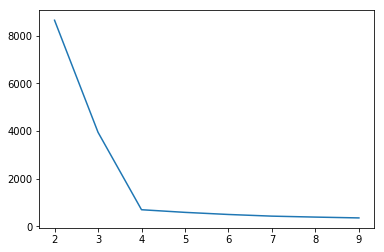

In [89]:
m_min = 2
m_max = 10
n_runs = 2
J_m = []
for m in range(m_min, m_max):
    J_temp_min = np.inf
    for t in range(n_runs):
        bel, cost, w, a = k_medoids(X, m)
        if(cost < J_temp_min):
            J_temp_min = cost
    J_m.append(J_temp_min)
plt.plot(range(m_min, m_max), J_m)
plt.show()

# Exercise 7.5.4

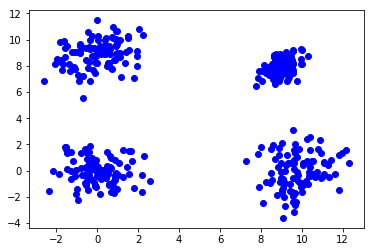

In [35]:
S1 = np.identity(2)
S2 = np.array([[1, 0.2], [0.2, 1.5]])
S3 = np.array([[1, 0.4], [0.4, 1.1]])
S4 = np.array([[0.3, 0.2], [0.2, 0.5]])
m1 = np.array([0, 0])
m2 = np.array([10, 0])
m3 = np.array([0, 9])
m4 = np.array([9, 8])
n = 100

x1 = np.random.multivariate_normal(m1, S1, n)
x2 = np.random.multivariate_normal(m2, S2, n)
x3 = np.random.multivariate_normal(m3, S3, n)
x4 = np.random.multivariate_normal(m4, S4, n)
X = np.concatenate([x1, x2, x3, x4])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

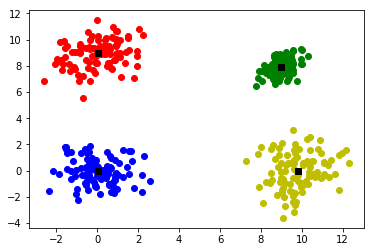

12.29966510984941


In [37]:
e = 10e-3
maxiter = 100
mv_ini = np.random.randint(0, 10, (4, 2))
mc_ini = np.array([S1, S2, S3, S4])
ap, cp, mv, mc, iters, loss = GMDAS(X,mv_ini,mc_ini,e,maxiter)

bel = np.argmax(cp, axis=1)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
X4 = X[np.where(bel == 3)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(mv[:, 0], mv[:, 1], "ks")
plt.show()
print(loss)

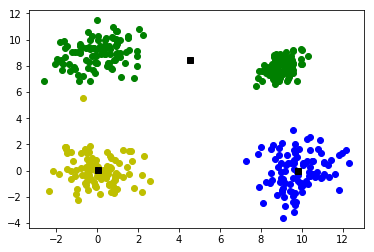

5.0566115743371896


In [38]:
e = 10e-3
maxiter = 100
mv_ini = np.random.randint(0, 10, (3, 2))
mc_ini = np.array([S1, S2, S3])
ap, cp, mv, mc, iters, loss = GMDAS(X,mv_ini,mc_ini,e,maxiter)

bel = np.argmax(cp, axis=1)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(mv[:, 0], mv[:, 1], "ks")
plt.show()
print(loss)

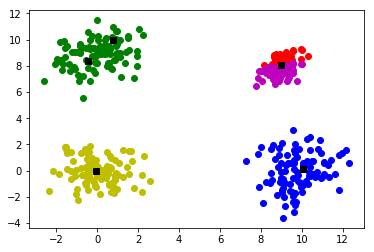

12.269322079513369


In [54]:
e = 10e-3
maxiter = 100
mv_ini = np.random.randint(0, 10, (5, 2))
mc_ini = np.array([S1, S2, S3, S4, S4])
ap, cp, mv, mc, iters, loss = GMDAS(X,mv_ini,mc_ini,e,maxiter)

bel = np.argmax(cp, axis=1)
X1 = X[np.where(bel == 0)]
X2 = X[np.where(bel == 1)]
X3 = X[np.where(bel == 2)]
X4 = X[np.where(bel == 3)]
X5 = X[np.where(bel == 4)]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(X5[:, 0], X5[:, 1], "mo")
plt.plot(w[:, 0], w[:, 1], "ks")
plt.show()
print(loss)

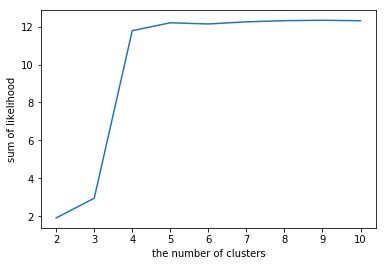

In [55]:
m_min = 2
m_max = 11
n_runs = 2
J_m = []
for m in range(m_min, m_max):
    J_temp_min = np.inf
    for t in range(n_runs):
        mv_ini = np.random.randint(0, 10, (m, 2))
        mc_ini = np.array([S1]*m)
        ap, cp, mv, mc, iters, loss = GMDAS(X,mv_ini,mc_ini,e,maxiter)
        if(loss < J_temp_min):
            J_temp_min = loss
    J_m.append(J_temp_min)
plt.plot(range(m_min, m_max), J_m)
plt.xlabel("the number of clusters")
plt.ylabel("sum of likelihood")
plt.show()

# Exercise 7.5.6

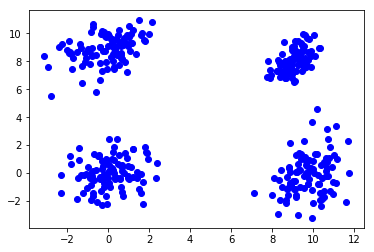

In [56]:
S1 = np.identity(2)
S2 = np.array([[1, 0.2], [0.2, 1.5]])
S3 = np.array([[1, 0.4], [0.4, 1.1]])
S4 = np.array([[0.3, 0.2], [0.2, 0.5]])
m1 = np.array([0, 0])
m2 = np.array([10, 0])
m3 = np.array([0, 9])
m4 = np.array([9, 8])
n = 100

x1 = np.random.multivariate_normal(m1, S1, n)
x2 = np.random.multivariate_normal(m2, S2, n)
x3 = np.random.multivariate_normal(m3, S3, n)
x4 = np.random.multivariate_normal(m4, S4, n)
X = np.concatenate([x1, x2, x3, x4])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

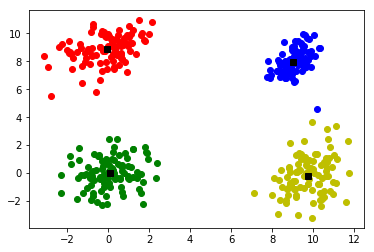

In [57]:
m = 4
q = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
X3 = X[cluster_membership == 2]
X4 = X[cluster_membership == 3]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.show()

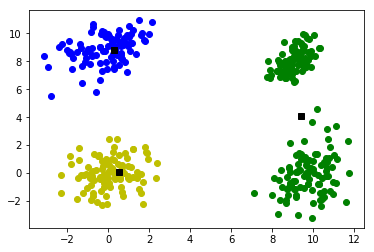

In [58]:
m = 3
q = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
X3 = X[cluster_membership == 2]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.show()

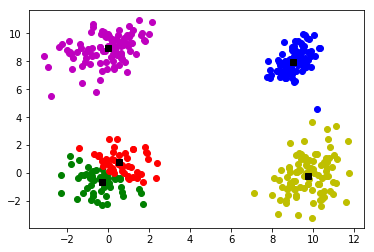

In [59]:
m = 5
q = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
X3 = X[cluster_membership == 2]
X4 = X[cluster_membership == 3]
X5 = X[cluster_membership == 4]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(X5[:, 0], X5[:, 1], "mo")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.show()

# Exercise 7.5.7

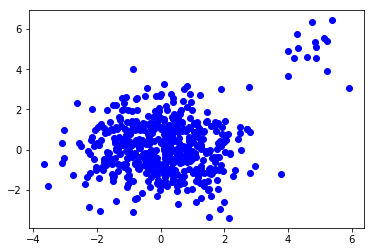

In [60]:
S1 = 1.5*np.identity(2)
S2 = np.identity(2)
m1 = np.array([0, 0])
m2 = np.array([5, 5])

x1 = np.random.multivariate_normal(m1, S1, 500)
x2 = np.random.multivariate_normal(m2, S2, 15)
X = np.concatenate([x1, x2])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

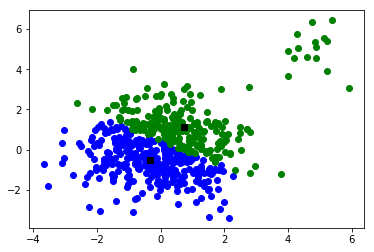

In [61]:
m = 2
q = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)

X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.show()

# Exercise 7.5.8

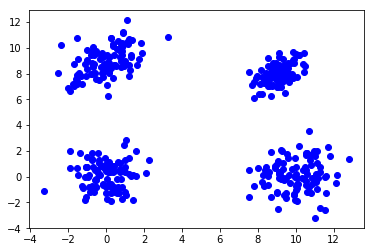

In [62]:
S1 = np.identity(2)
S2 = np.array([[1, 0.2], [0.2, 1.5]])
S3 = np.array([[1, 0.4], [0.4, 1.1]])
S4 = np.array([[0.3, 0.2], [0.2, 0.5]])
m1 = np.array([0, 0])
m2 = np.array([10, 0])
m3 = np.array([0, 9])
m4 = np.array([9, 8])
n = 100

x1 = np.random.multivariate_normal(m1, S1, n)
x2 = np.random.multivariate_normal(m2, S2, n)
x3 = np.random.multivariate_normal(m3, S3, n)
x4 = np.random.multivariate_normal(m4, S4, n)
X = np.concatenate([x1, x2, x3, x4])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

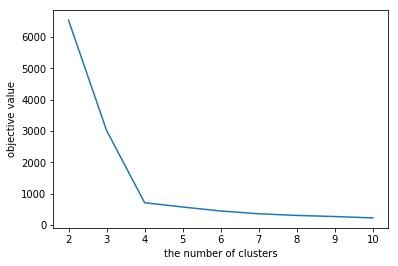

In [63]:
m_min = 2
m_max = 11
n_runs = 10
J_m = []
for m in range(m_min, m_max):
    J_temp_min = np.inf
    for t in range(n_runs):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
        if(jm[-1] < J_temp_min):
            J_temp_min = jm[-1]
    J_m.append(J_temp_min)
plt.plot(range(m_min, m_max), J_m)
plt.xlabel("the number of clusters")
plt.ylabel("objective value")
plt.show()

# Exercise 7.5.9

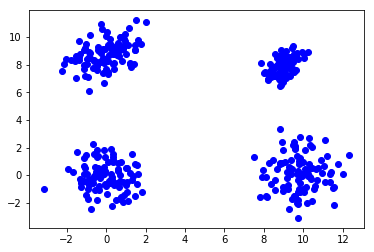

In [83]:
S1 = np.identity(2)
S2 = np.array([[1, 0.2], [0.2, 1.5]])
S3 = np.array([[1, 0.4], [0.4, 1.1]])
S4 = np.array([[0.3, 0.2], [0.2, 0.5]])
m1 = np.array([0, 0])
m2 = np.array([10, 0])
m3 = np.array([0, 9])
m4 = np.array([9, 8])
n = 100

x1 = np.random.multivariate_normal(m1, S1, n)
x2 = np.random.multivariate_normal(m2, S2, n)
x3 = np.random.multivariate_normal(m3, S3, n)
x4 = np.random.multivariate_normal(m4, S4, n)
X = np.concatenate([x1, x2, x3, x4])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.show()

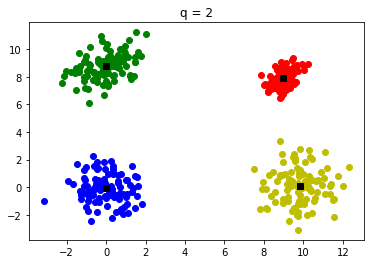

In [84]:
m = 4
q = 2
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)
U0 = np.max(u, axis=0)
X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
X3 = X[cluster_membership == 2]
X4 = X[cluster_membership == 3]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.title("q = 2")
plt.show()

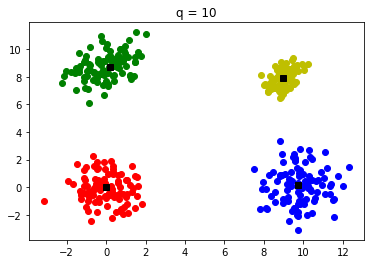

In [85]:
m = 4
q = 10
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)
U1 = np.max(u, axis=0)
X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
X3 = X[cluster_membership == 2]
X4 = X[cluster_membership == 3]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.title("q = 10")
plt.show()

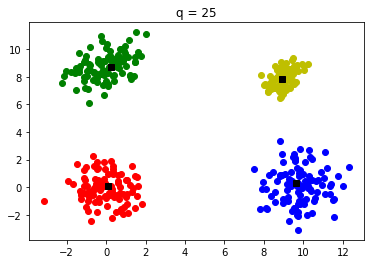

In [86]:
m = 4
q = 25
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X.T, m, q, error=0.005, maxiter=1000)
cluster_membership = np.argmax(u, axis=0)
U2 = np.max(u, axis=0)
X1 = X[cluster_membership == 0]
X2 = X[cluster_membership == 1]
X3 = X[cluster_membership == 2]
X4 = X[cluster_membership == 3]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.plot(cntr[:, 0], cntr[:, 1], "ks")
plt.title("q = 25")
plt.show()

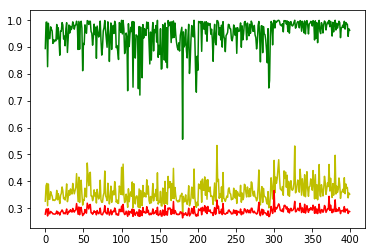

the greater of q, the smaller of probability


In [87]:
plt.plot(U0, "g-", label='q = 2')
plt.plot(U1, "y-", label='q = 10')
plt.plot(U2, "r-", label='q = 25')
plt.show()
print("the greater of q, the smaller of probability")

# Exercise 7.7.1

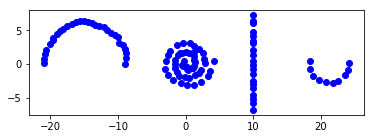

In [79]:
n_points = [30, 20, 10, 50]
noise = 0.5

#first group
R = 6
theta = np.linspace(0, np.pi, n_points[0])
ran = noise*np.random.rand(n_points[0])
x = -15 + R*np.cos(theta) + ran
y = 0 + R*np.sin(theta) + ran
X1 = np.array([x, y]).T


#second group
x = 10*np.ones(n_points[1])
y = noise*np.random.rand(n_points[1]) + np.linspace(-7, 7, n_points[1])
X2 = np.array([x, y]).T


#third group
R = 3
theta = np.linspace(-np.pi, 0, n_points[2])
ran = noise*np.random.rand(n_points[2])
x = 21 + R*np.cos(theta) + ran
y = 0 + R*np.sin(theta) + ran
X3 = np.array([x, y]).T

#fourth
a = 0.2
theta = np.linspace(np.pi, 6*np.pi, n_points[3])
ran = noise*np.random.rand(n_points[3])
x = a*theta*np.cos(theta) + ran
y = a*theta*np.sin(theta) + ran
X4 = np.array([x, y]).T

X = np.concatenate([X1, X2, X3, X4])
plt.plot(X[:, 0], X[:, 1], "bo")
plt.gca().set_aspect('equal', 'box')
plt.show()

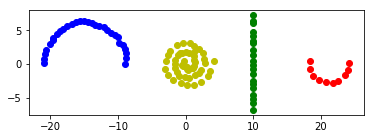

In [80]:
clustering = AgglomerativeClustering(n_clusters = 4).fit(X)
X1 = X[clustering.labels_ == 0]
X2 = X[clustering.labels_ == 1]
X3 = X[clustering.labels_ == 2]
X4 = X[clustering.labels_ == 3]
plt.plot(X1[:, 0], X1[:, 1], "bo")
plt.plot(X2[:, 0], X2[:, 1], "go")
plt.plot(X3[:, 0], X3[:, 1], "yo")
plt.plot(X4[:, 0], X4[:, 1], "ro")
plt.gca().set_aspect('equal', 'box')
plt.show()

based on the dissimilarity level => select 4 clusters


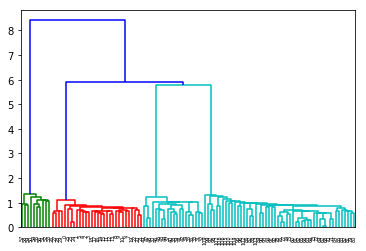

In [81]:
Z = hierarchy.linkage(X, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)
print("based on the dissimilarity level => select 4 clusters")

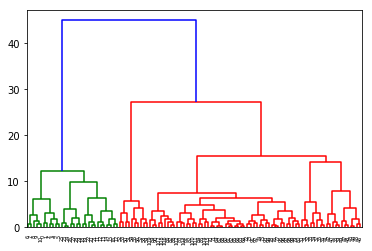

In [82]:
Z = hierarchy.linkage(X, 'complete')
plt.figure()
dn = hierarchy.dendrogram(Z)